# **Khởi tạo**

**Import thư viện**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, LSTM, Dense, Flatten, Reshape
import os

**Đọc và xử lý dữ liệu**

In [16]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data = data[['Price']]

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)
    data = data.reset_index()['Price']

    return data

**Xây dựng mô hình**

In [17]:
# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
# Hàm Create Dataset
def create_dataset(dataset, seq_size=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        dataX.append(window)
        dataY.append(dataset[i + seq_size, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
def LSTM_prediction(name, data, train_ratio=0.7, days=30):

    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(np.array(data).reshape(-1,1))

    # Chia train, test
    train_size = int(train_ratio * len(data))
    test_size = len(data) - train_size
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    seq_size = 100
    X_train, y_train = create_dataset(train_data, seq_size)
    X_test, y_test = create_dataset(test_data, seq_size)
    
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  
    # Xây dựng mô hình LSTM
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    # model.summary()
    
    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    # Đánh giá độ chính xác thuật toán bằng RMSE
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Testing RMSE:', test_rmse)

    # Đánh giá độ chính xác thuật toán bằng MAE
    test_mae = mean_absolute_error(y_test, y_pred)
    print('Testing MAE:', test_mae)
    
    # Đánh giá độ chính xác thuật toán bằng MAPE
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    print('Testing MAPE:', test_mape)

    # Dự báo các ngày tiếp theo
    x_input = test_data[-seq_size:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < days:
        if len(temp_input) > seq_size:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, seq_size, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, seq_size, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
    
    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    
    # Vẽ hình
    plt.figure(figsize=(10, 6))
    plt.title('LSTM {} ({})'.format(train_ratio, name))
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+seq_size+1, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))
    prediect_data_index = pd.RangeIndex(start=len(data)-1, stop=len(data)+days-1, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
    plt.legend(['Train','Test','Predict','Predict'+str(days)+'days'])
    plt.show()
    

# **BIDV**

In [20]:
data = read_file("../Dataset/BID Historical Data.csv");
name = 'BIDV'

## **30 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Testing RMSE: 0.17526064183918588
Testing MAE: 0.02910593936129505
Testing MAPE: 20.2137841873461


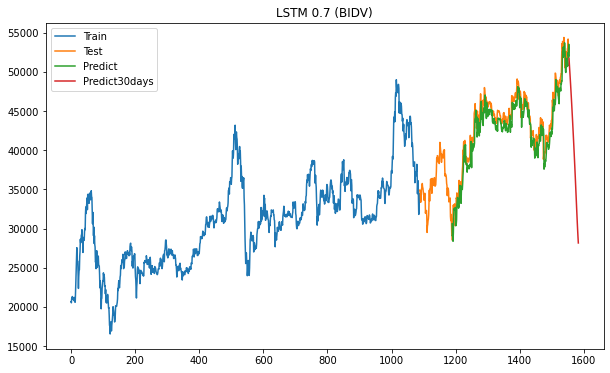

<Figure size 432x288 with 0 Axes>

In [21]:
LSTM_prediction(name, data, 0.7)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing RMSE: 0.13566428184964313
Testing MAE: 0.02001436844966323
Testing MAPE: 14.252197696560506


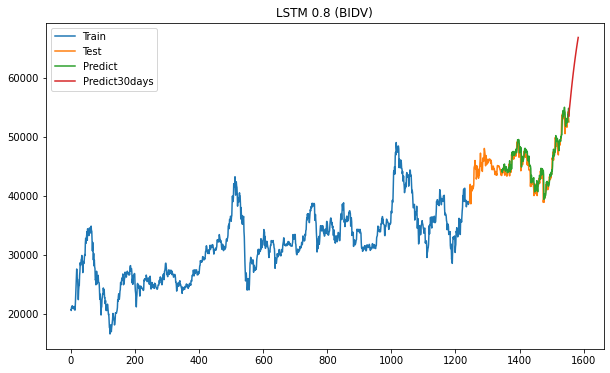

<Figure size 432x288 with 0 Axes>

In [22]:
LSTM_prediction(name, data, 0.8)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Testing RMSE: 0.10677713935594926
Testing MAE: 0.019277148891119502
Testing MAPE: 9.917569843503243


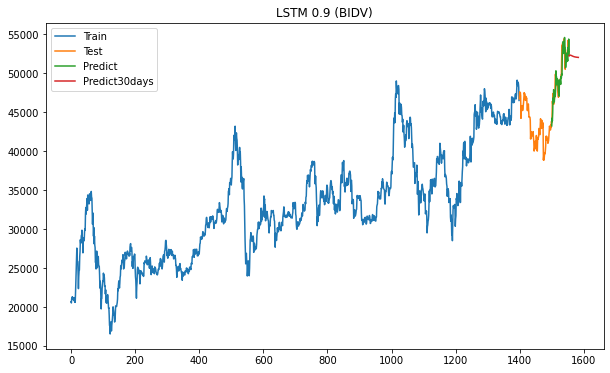

<Figure size 432x288 with 0 Axes>

In [23]:
LSTM_prediction(name, data, 0.9)

## **60 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing RMSE: 0.17556510489655572
Testing MAE: 0.01809867524347552
Testing MAPE: 20.627868235010645


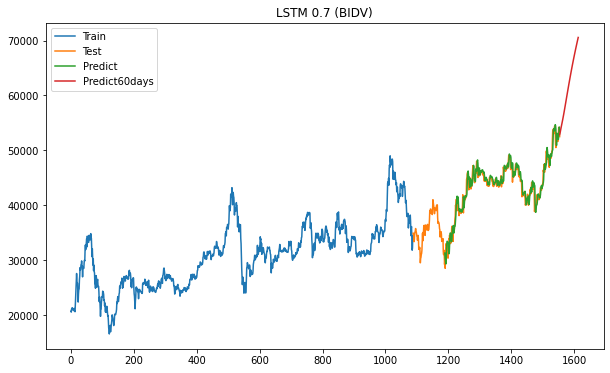

<Figure size 432x288 with 0 Axes>

In [24]:
LSTM_prediction(name, data, 0.7, 60)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Testing RMSE: 0.1365651804855928
Testing MAE: 0.01782924178924114
Testing MAPE: 14.093277986728081


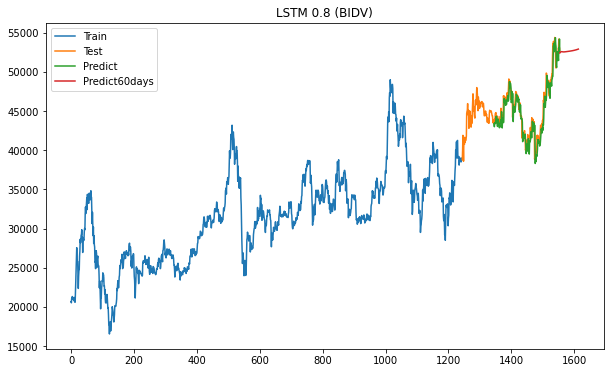

<Figure size 432x288 with 0 Axes>

In [25]:
LSTM_prediction(name, data, 0.8, 60)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Testing RMSE: 0.10887179882551223
Testing MAE: 0.020994869452487446
Testing MAPE: 10.194074461625762


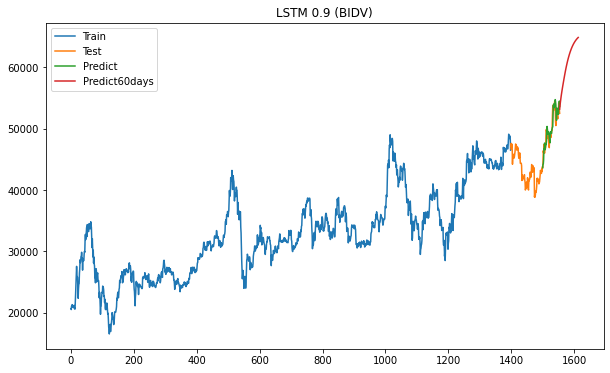

<Figure size 432x288 with 0 Axes>

In [26]:
LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing RMSE: 0.17121281982766226
Testing MAE: 0.033636684569573874
Testing MAPE: 19.715311534316854


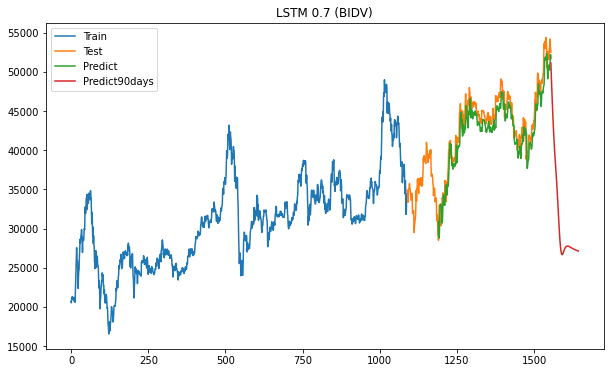

<Figure size 432x288 with 0 Axes>

In [27]:
LSTM_prediction(name, data, 0.7, 90)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Testing RMSE: 0.1328255095309863
Testing MAE: 0.01799174491535995
Testing MAPE: 13.71061173100148


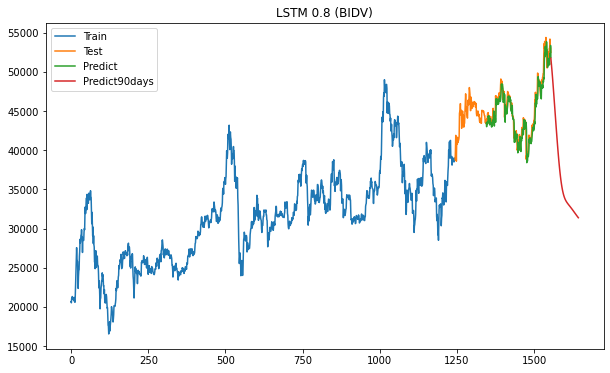

<Figure size 432x288 with 0 Axes>

In [28]:
LSTM_prediction(name, data, 0.8, 90)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Testing RMSE: 0.10807038337812476
Testing MAE: 0.026528481165615313
Testing MAPE: 9.936641881103117


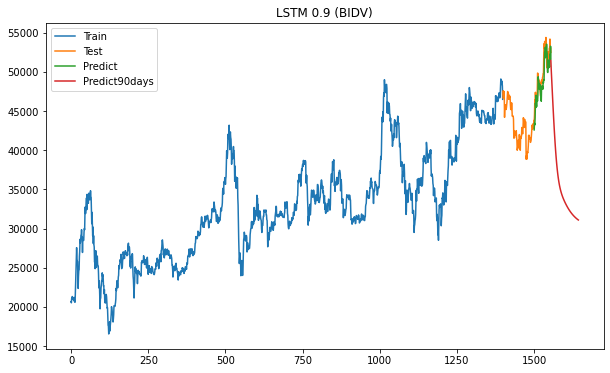

<Figure size 432x288 with 0 Axes>

In [29]:
LSTM_prediction(name, data, 0.9, 90)

# **VCB**

In [30]:
data = read_file("../Dataset/VCB Historical Data.csv");
name = 'VCB'

## **30 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Testing RMSE: 0.15683681195830745
Testing MAE: 0.024218946534106302
Testing MAPE: 17.22544223104963


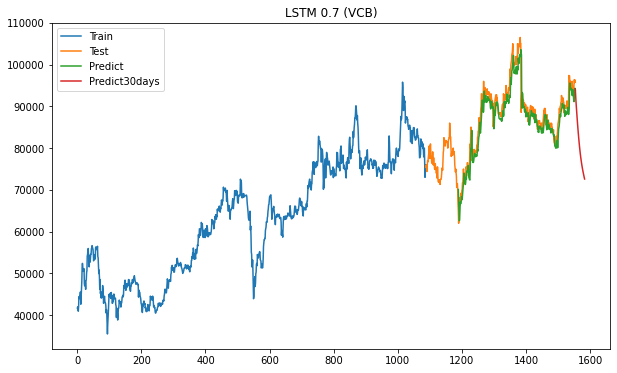

<Figure size 432x288 with 0 Axes>

In [31]:
LSTM_prediction(name, data, 0.7)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Testing RMSE: 0.11854899994219777
Testing MAE: 0.020749303058286876
Testing MAPE: 11.89845347992861


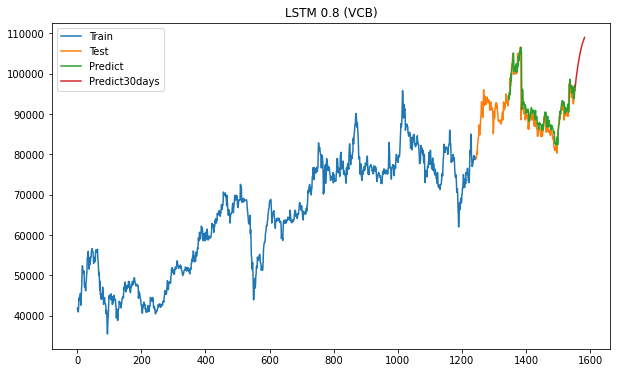

<Figure size 432x288 with 0 Axes>

In [32]:
LSTM_prediction(name, data, 0.8)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Testing RMSE: 0.06451819014967923
Testing MAE: 0.01676960370350682
Testing MAPE: 6.578681207832471


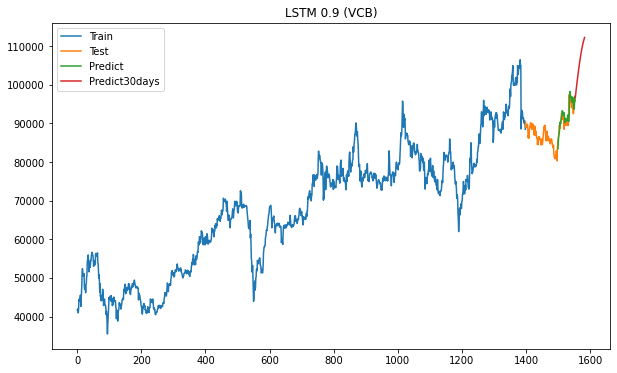

<Figure size 432x288 with 0 Axes>

In [33]:
LSTM_prediction(name, data, 0.9)

## **60 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing RMSE: 0.15632543886852449
Testing MAE: 0.02217963239978077
Testing MAPE: 17.194667290808


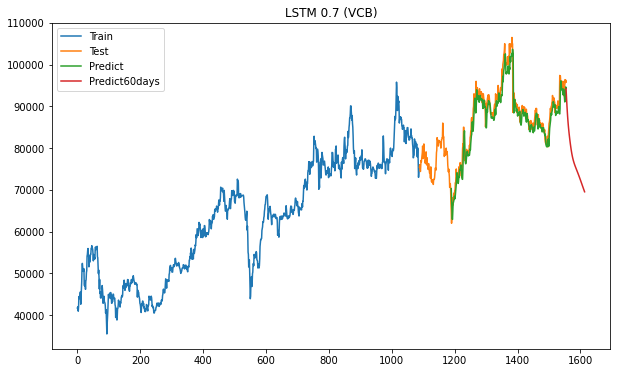

<Figure size 432x288 with 0 Axes>

In [34]:
LSTM_prediction(name, data, 0.7, 60)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Testing RMSE: 0.11703666199538021
Testing MAE: 0.01512515323371827
Testing MAPE: 11.496496780237043


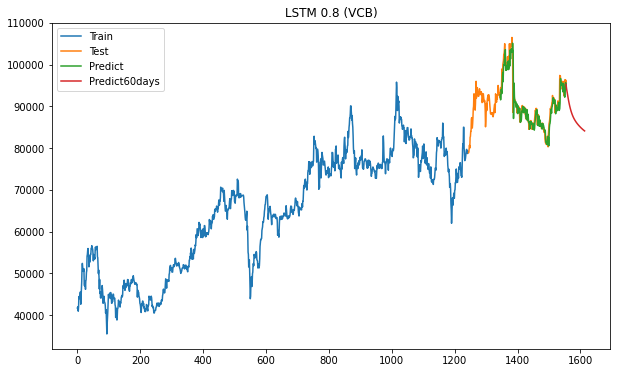

<Figure size 432x288 with 0 Axes>

In [35]:
LSTM_prediction(name, data, 0.8, 60)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Testing RMSE: 0.06280837064945892
Testing MAE: 0.012024792371395506
Testing MAPE: 6.28279999247915


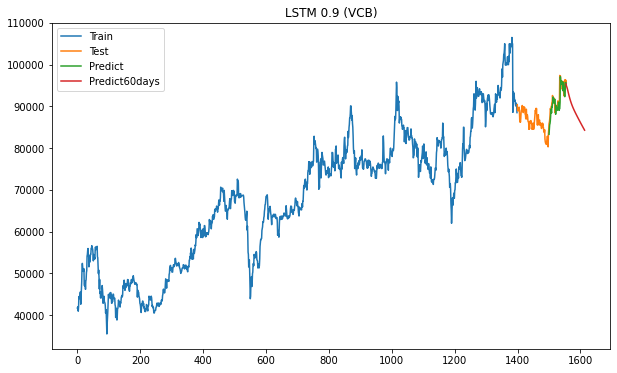

<Figure size 432x288 with 0 Axes>

In [36]:
LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Testing RMSE: 0.15565154955535443
Testing MAE: 0.022230302925605232
Testing MAPE: 17.12321553625594


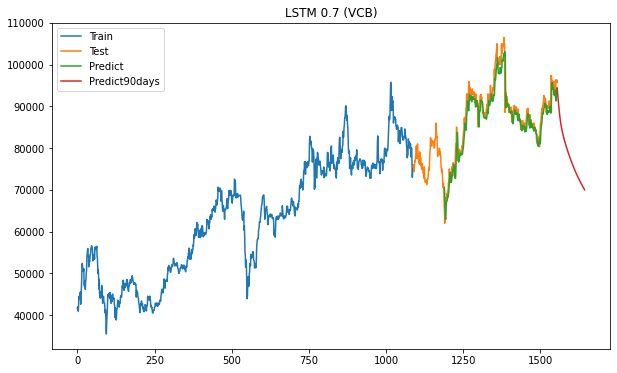

<Figure size 432x288 with 0 Axes>

In [37]:
LSTM_prediction(name, data, 0.7, 90)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Testing RMSE: 0.1153785541858702
Testing MAE: 0.017229591180665
Testing MAPE: 11.316113352038702


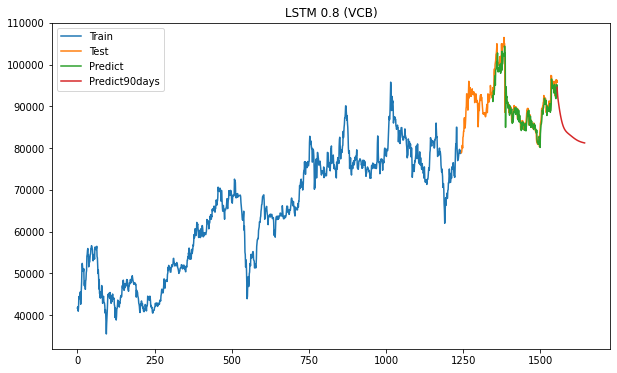

<Figure size 432x288 with 0 Axes>

In [38]:
LSTM_prediction(name, data, 0.8, 90)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Testing RMSE: 0.0659801228647528
Testing MAE: 0.021781850414488577
Testing MAPE: 6.819173945188048


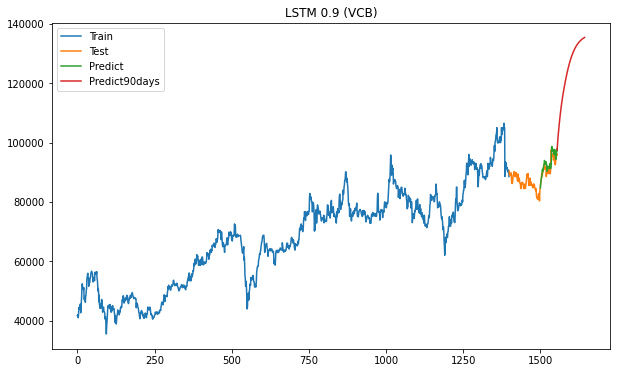

<Figure size 432x288 with 0 Axes>

In [39]:
LSTM_prediction(name, data, 0.9, 90)

# **MBB**

In [40]:
data = read_file("../Dataset/MBB Historical Data.csv");
name = 'MBB'

## **30 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Testing RMSE: 0.1293045099891505
Testing MAE: 0.020689412691791004
Testing MAPE: 16.865548093684417


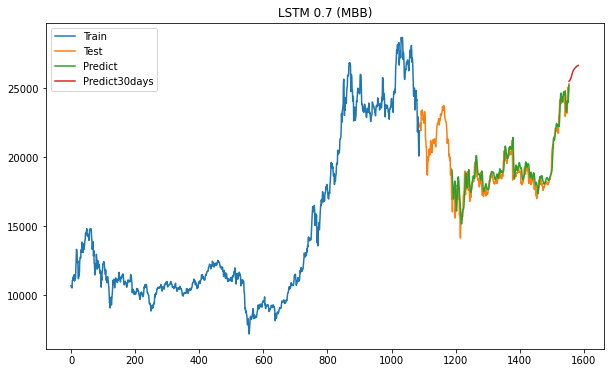

<Figure size 432x288 with 0 Axes>

In [41]:
LSTM_prediction(name, data, 0.7)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Testing RMSE: 0.1373260870425555
Testing MAE: 0.014034061178852817
Testing MAPE: 17.237479256065647


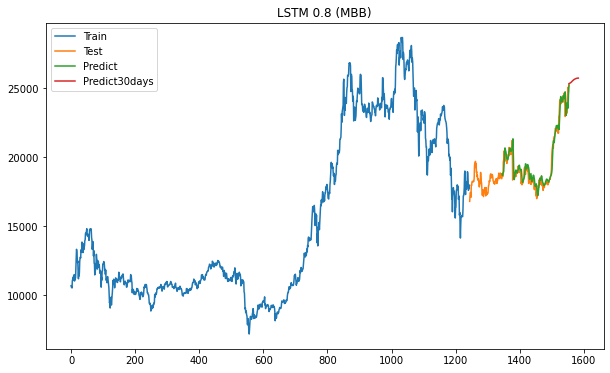

<Figure size 432x288 with 0 Axes>

In [42]:
LSTM_prediction(name, data, 0.8)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Testing RMSE: 0.0964900227347996
Testing MAE: 0.014997763828637285
Testing MAPE: 10.714055835579932


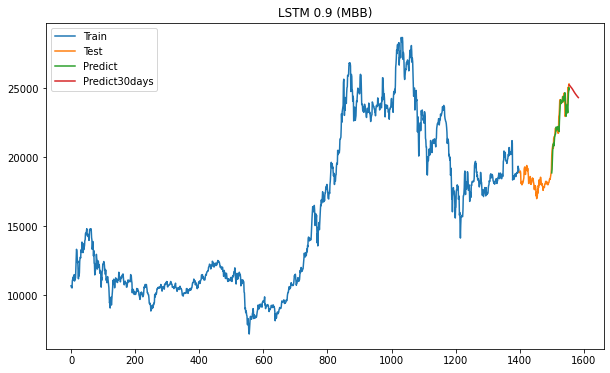

<Figure size 432x288 with 0 Axes>

In [43]:
LSTM_prediction(name, data, 0.9)

## **60 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Testing RMSE: 0.12875652717595534
Testing MAE: 0.015525236167790495
Testing MAPE: 16.57081342183068


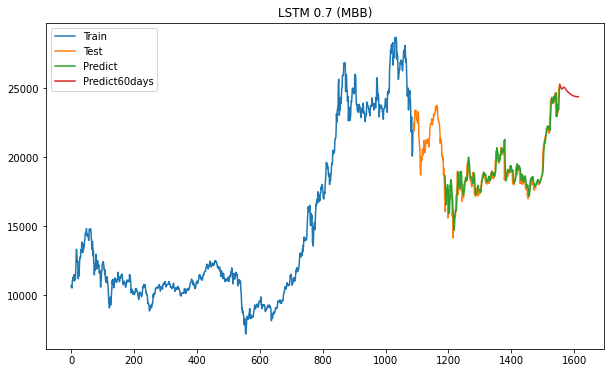

<Figure size 432x288 with 0 Axes>

In [44]:
LSTM_prediction(name, data, 0.7, 60)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Testing RMSE: 0.1353881306696313
Testing MAE: 0.02119866391622893
Testing MAPE: 16.620478619580222


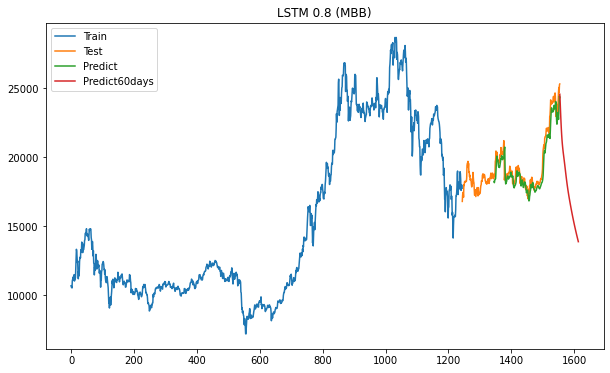

<Figure size 432x288 with 0 Axes>

In [45]:
LSTM_prediction(name, data, 0.8, 60)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Testing RMSE: 0.0990477236624437
Testing MAE: 0.02572603672381714
Testing MAPE: 10.883809832227248


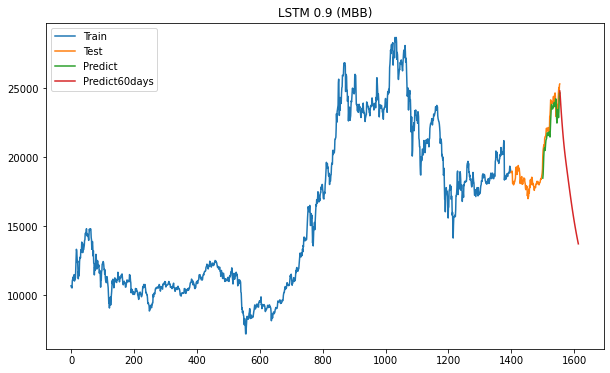

<Figure size 432x288 with 0 Axes>

In [46]:
LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Testing RMSE: 0.1272794199449214
Testing MAE: 0.017052325232206393
Testing MAPE: 16.188245322355634


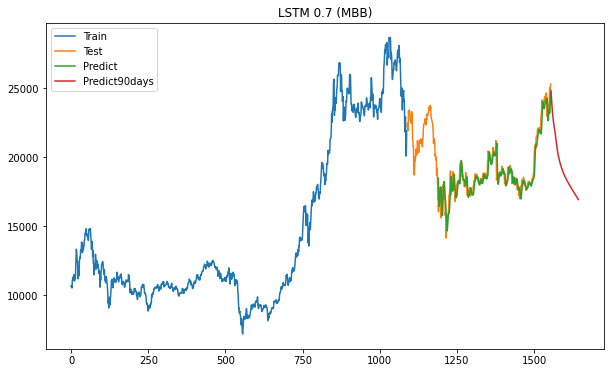

<Figure size 432x288 with 0 Axes>

In [47]:
LSTM_prediction(name, data, 0.7, 90)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Testing RMSE: 0.13695175561280723
Testing MAE: 0.012050836579417405
Testing MAPE: 17.060529778622946


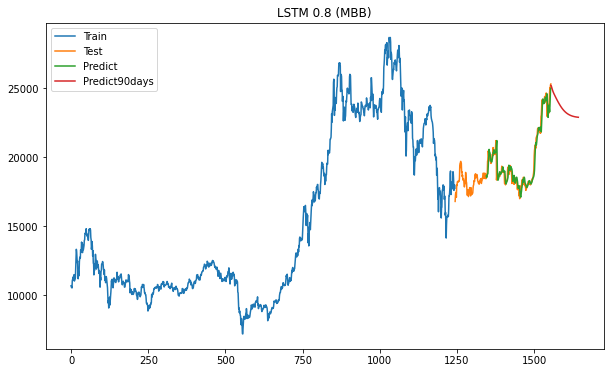

<Figure size 432x288 with 0 Axes>

In [48]:
LSTM_prediction(name, data, 0.8, 90)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Testing RMSE: 0.10004264501922029
Testing MAE: 0.02161252741035641
Testing MAPE: 11.347264616596862


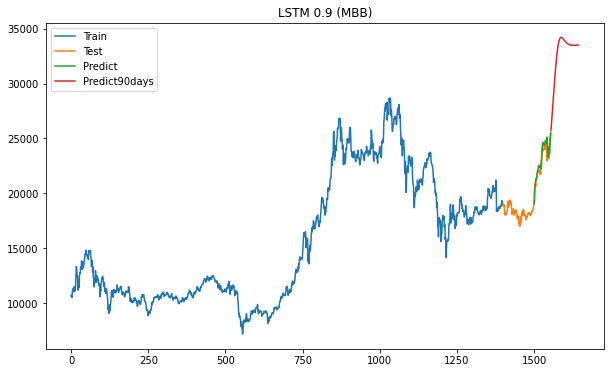

<Figure size 432x288 with 0 Axes>

In [49]:
LSTM_prediction(name, data, 0.9, 90)